In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from ricci.simplicial_complex import SimplicialComplex
from ricci.ricci_flow import ricci_flow_community_detection
import matplotlib.pyplot as plt
import itertools
import networkx as nx


In [3]:
import pandas as pd

df = pd.read_table("../datasets/aves-weaver-social.edges", names=['source', 'target', 'true'], sep=' ')
true_labels = df['true'].tolist()
edges = [set([row['source'], row['target']]) for _, row in df.iterrows()]
nodes = set(df['source']).union(set(df['target']))
node_labels = dict(zip(df['source'], df['true']))

Dimensions and counts of simplices in the complex:
Dimension 0: 445 simplices
Dimension 1: 1335 simplices
Dimension 2: 246 simplices
Dimension 3: 51 simplices
Iteration 1/2
Iteration 2/2
Weight range after flow: min=0.747, max=0.854


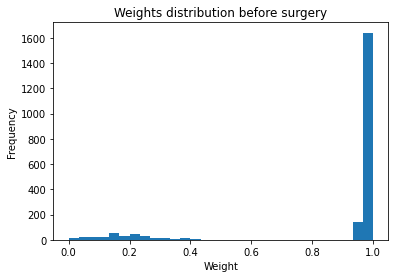

 θ=0.447 → 445 communities
 θ=0.448 → 445 communities
 θ=0.449 → 445 communities
 θ=0.450 → 445 communities
 θ=0.451 → 445 communities
 θ=0.452 → 445 communities
 θ=0.453 → 445 communities
 θ=0.454 → 445 communities
 θ=0.455 → 445 communities
 θ=0.456 → 445 communities
 θ=0.457 → 445 communities
 θ=0.458 → 445 communities
 θ=0.459 → 445 communities
 θ=0.460 → 445 communities
 θ=0.461 → 445 communities
 θ=0.462 → 445 communities
 θ=0.463 → 445 communities
 θ=0.464 → 445 communities
 θ=0.465 → 445 communities
 θ=0.466 → 445 communities
 θ=0.467 → 445 communities
 θ=0.468 → 445 communities
 θ=0.469 → 445 communities
 θ=0.470 → 445 communities
 θ=0.471 → 445 communities
 θ=0.472 → 445 communities
 θ=0.473 → 445 communities
 θ=0.474 → 445 communities
 θ=0.475 → 445 communities
 θ=0.476 → 445 communities
 θ=0.477 → 445 communities
 θ=0.478 → 445 communities
 θ=0.479 → 445 communities
 θ=0.480 → 445 communities
 θ=0.481 → 445 communities
 θ=0.482 → 445 communities
 θ=0.483 → 445 communities
 

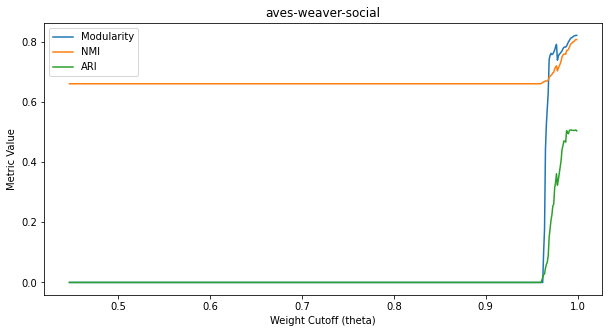

Optimal theta (based on NMI): 0.9980475838630232
Number of communities detected: 462


In [4]:
sc = SimplicialComplex()

for node in nodes:
    sc.add_simplex((node,))

for edge in edges:
    sc.add_simplex(edge)

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

max_clique_size = 4  
cliques = list(nx.find_cliques(G))

for clique in cliques:
    if len(clique) > 2 and len(clique) <= max_clique_size:
        for k in range(2, len(clique)):
            for simplex in itertools.combinations(clique, k+1):
                sc.add_simplex(simplex)

print("Dimensions and counts of simplices in the complex:")
for dim in sc.simplices:
    count = len(sc.simplices[dim])
    print(f"Dimension {dim}: {count} simplices")

max_dim = max(sc.simplices.keys())
nmi_scores, modularity_scores, theta_values, ari_scores = ricci_flow_community_detection(
    sc, T=2, delta=0.1, ground_truth=node_labels
)

plt.figure(figsize=(10,5))
plt.plot(theta_values, modularity_scores, label='Modularity')
plt.plot(theta_values, nmi_scores, label='NMI')
plt.plot(theta_values, ari_scores, label='ARI') 
plt.xlabel('Weight Cutoff (theta)')
plt.ylabel('Metric Value')
plt.title('aves-weaver-social')
plt.legend()
plt.grid(False)
plt.show()

if nmi_scores:
    max_nmi_index = nmi_scores.index(max(nmi_scores))
    optimal_theta = theta_values[max_nmi_index]
    print(f"Optimal theta (based on NMI): {optimal_theta}")
else:
    print("Could not compute NMI scores.")

sc.simplices = {dim: sc.simplices[dim].copy() for dim in sc.simplices}
sc.weights = sc.weights.copy()

simplices_to_remove = [simplex for simplex, weight in sc.weights.items()
                       if weight > optimal_theta and len(simplex) > 1]
for simplex in simplices_to_remove:
    dim = len(simplex) - 1
    if simplex in sc.simplices[dim]:
        sc.simplices[dim].remove(simplex)
    del sc.weights[simplex]

G = nx.Graph()
G.add_nodes_from(sc.simplices[0])
G.add_edges_from(sc.simplices[1])

communities = list(nx.connected_components(G))
print(f"Number of communities detected: {len(communities)}")